In [14]:
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
from PIL import Image
from matplotlib import pyplot as plt
from scipy.linalg import norm

In [15]:
def loss_plot(loss):
    '''
    loss is a list, this function plots loss over iteration
    '''
    plt.plot(list(range(1, len(loss)+1)), loss)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('Loss Over Iteration')
    plt.show()

In [16]:

def U_theta(num_qubits: int, depth: int):
    dev = qml.device("default.qubit", wires=num_qubits)    
    @qml.qnode(dev)
    def circuit(params):
        # params shape: (depth, 2, num_qubits)
        for d in range(depth):
            for q in range(num_qubits):
                qml.RY(params[d, 0, q], wires=q)
                qml.RZ(params[d, 1, q], wires=q)
            for q in range(num_qubits - 1):
                qml.CNOT(wires=[q, q + 1])
        return qml.state()
    
    # Número de parámetros: depth x 2 x num_qubits
    return circuit, (depth, 2, num_qubits)


def ansatz(params, wires):
    depth = params.shape[0]
    num_qubits = len(wires)
    for d in range(depth):
        for q in range(num_qubits):
            qml.RY(params[d, 0, q], wires=wires[q])
            qml.RZ(params[d, 1, q], wires=wires[q])
        for q in range(num_qubits - 1):
            qml.CNOT(wires=[wires[q], wires[q+1]])


def get_unitary_matrix(ansatz_fn, params, num_qubits):
    dev = qml.device("default.qubit", wires=num_qubits)
    basis_states = [format(i, f"0{num_qubits}b") for i in range(2**num_qubits)]
    matrix_columns = []

    @qml.qnode(dev)
    def basis_circuit(state_bin, params):
        # Prepare basis state
        for j, bit in enumerate(reversed(state_bin)):
            if bit == "1":
                qml.PauliX(wires=j)
        ansatz_fn(params, wires=range(num_qubits))
        return qml.state()

    for b in basis_states:
        final_state = basis_circuit(b, params)
        matrix_columns.append(final_state)
    return pnp.column_stack(matrix_columns)

In [17]:
class VQSVD():
    def __init__(self, matrix: pnp.ndarray, 
                 weights: pnp.ndarray, 
                 num_qubits: int, depth: int, rank: int, 
                 lr: float, itr: int, seed: int):

        # Hyperparameters
        self.rank = rank
        self.lr = lr
        self.itr = itr
        self.num_qubits = num_qubits
        self.depth = depth

        pnp.random.seed(seed)

        # Parameter shapes for U and V
        self.param_shape = (depth, 2,num_qubits)
        self.theta = pnp.random.uniform(0, 2*pnp.pi, self.param_shape, requires_grad=True)
        self.phi = pnp.random.uniform(0, 2*pnp.pi, self.param_shape, requires_grad=True)

        # Ansatz function (should be defined outside the class)
        self.ansatz = ansatz

        # Matrix and weights
        self.M = pnp.array(matrix)
        self.weight = pnp.array(weights)


        self.U = get_unitary_matrix(self.ansatz, self.theta, self.num_qubits)
        self.V = get_unitary_matrix(self.ansatz, self.phi, self.num_qubits)

    def get_matrix_U(self):
        return self.U

    def get_matrix_V(self):
        return self.V

   

    def loss_func(self, theta, phi):
        self.U = get_unitary_matrix(self.ansatz, theta, self.num_qubits)
        self.V = get_unitary_matrix(self.ansatz, phi, self.num_qubits)
        loss = pnp.array(0.0)
        singular_values = []
        for i in range(self.rank):
            value = pnp.real(pnp.conj(self.U.T) @ self.M @ self.V)[i, i]
            #print(f'Singular value {i}: {value}')
            loss -= pnp.real(self.weight)[i] * value
            singular_values.append(value)

        # Conversión a numpy clásico para graficar sin problemas
        return loss, singular_values

    # Train the VQSVD network
    def train(self):
        loss_list, singular_value_list = [], []
        optimizer = qml.AdamOptimizer(self.lr)
        theta = self.theta
        phi = self.phi
        for itr in range(self.itr):
            (theta, phi), loss = optimizer.step_and_cost(
                lambda t, p: self.loss_func(t, p)[0], theta, phi
            )
            loss_val, singular_values = self.loss_func(theta, phi)
            loss_list.append(loss_val)
            singular_value_list.append(singular_values)
            if itr % 10 == 0:
                print(f'iter: {itr}, loss: {loss_val:.4f}')
        # Save final parameters
        self.theta = theta
        self.phi = phi
        return loss_list, singular_value_list

In [18]:
# Generate matrix M
# Make a random matrix generator

N = 2

def random_M_generator():
    M = np.random.randint(10, size = (2**N, 2**N)) + 1j*np.random.randint(10, size = (2**N, 2**N))
    return M

M = random_M_generator()
M_err = np.copy(M)
print(f'Matrix M shape: {M.shape}')

Matrix M shape: (4, 4)


In [19]:
# Set circuit parameters
num_qubits = 2              # number of qubits
cir_depth = 20              # circuit depth

# Hyperparameter settings
RANK = 4       # Set the number of rank you want to learn
ITR = 100   # Number of iterations
LR = 0.02   # Learning rate
SEED = 14   # Random seed

# Set the learning weight 
weight = np.arange(3 * RANK, 0, -3).astype('complex128')
print('The selected weight is:')
print(weight)

The selected weight is:
[12.+0.j  9.+0.j  6.+0.j  3.+0.j]


iter: 0, loss: -222.5619
iter: 10, loss: -404.9241
iter: 20, loss: -423.0273
iter: 30, loss: -430.1536
iter: 40, loss: -435.4490
iter: 50, loss: -438.0817
iter: 60, loss: -438.6322
iter: 70, loss: -438.7955
iter: 80, loss: -438.8377
iter: 90, loss: -438.8722


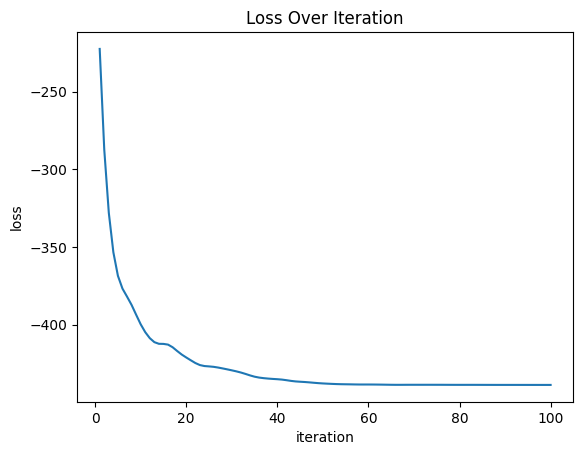

In [20]:
# Record the optimization process
loss_list, singular_value_list = [], []
U_learned, V_dagger_learned = [], []


# Construct the VQSVD network and train
net = VQSVD(matrix=M, weights=weight, num_qubits=num_qubits, depth=cir_depth, rank=RANK, lr=LR, itr=ITR, seed=SEED)
loss_list, singular_value_list = net.train()

# Draw a learning curve
loss_plot(loss_list)

# Record the last two learned unitary matrices
U_learned = net.get_matrix_U().numpy() 
V_dagger_learned =  net.get_matrix_V().numpy().conj().T

[25.2648525  10.84198159  5.9535515   2.5872549 ]
[25.25790128 10.81178293  5.83936599  1.149151  ]
[[2.+1.j 5.+1.j 4.+4.j 9.+4.j]
 [4.+0.j 8.+4.j 1.+2.j 8.+3.j]
 [9.+6.j 8.+1.j 6.+1.j 1.+3.j]
 [0.+0.j 7.+2.j 6.+4.j 7.+9.j]]


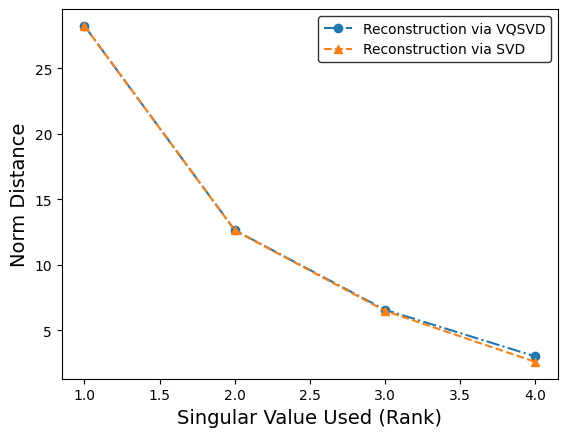

In [21]:
#singular_value = singular_value_list[-1]
err_subfull, err_local, err_SVD = [], [], []
U, D, V_dagger = np.linalg.svd(M, full_matrices=True)

singular_value_pnp = pnp.array(singular_value_list[-1]) # This is still a pnp.ndarray
singular_value = singular_value_pnp.numpy()

# Ordenar los valores singulares y ajustar U_learned y V_dagger_learned en consecuencia
#sorted_indices = np.argsort(singular_value)[::-1]  # índices ordenados de mayor a menor
#singular_value = singular_value[sorted_indices]
#U_learned = U_learned[:, sorted_indices]
#V_dagger_learned = V_dagger_learned[sorted_indices, :]

# Calculate the Frobenius-norm error
for i in range(RANK):
    lowrank_mat = U[:, :i] @ np.diag(D[:i]) @ V_dagger[:i, :]
    recons_mat = U_learned[:, :i] @ np.diag(singular_value[:i]) @ V_dagger_learned[:i, :]
    err_local.append(norm(lowrank_mat - recons_mat)) 
    err_subfull.append(norm(M_err - recons_mat))
    err_SVD.append(norm(M_err - lowrank_mat))

# Plot
fig, ax = plt.subplots()
ax.plot(list(range(1, RANK+1)), err_subfull, "o-.", 
        label = 'Reconstruction via VQSVD')
ax.plot(list(range(1, RANK+1)), err_SVD, "^--", 
        label='Reconstruction via SVD')
plt.xlabel('Singular Value Used (Rank)', fontsize = 14)
plt.ylabel('Norm Distance', fontsize = 14)
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('k')
print(D)
print(singular_value)
print(M_err )

In [22]:
def es_unitaria(mat, tol=1e-6):
    identidad = np.eye(mat.shape[0])
    producto = np.dot(mat, mat.conj().T)
    return np.allclose(producto, identidad, atol=tol)

print("¿U_learned es unitaria?:", es_unitaria(U))
print("¿U_learned es unitaria?:", es_unitaria(U_learned))
print("¿V_dagger_learned es unitaria?:", es_unitaria(V_dagger_learned))


¿U_learned es unitaria?: True
¿U_learned es unitaria?: True
¿V_dagger_learned es unitaria?: True


In [23]:
# Image processing package PIL
from PIL import Image

# Open the picture prepared in advance
img = Image.open('./figures/MNIST_32.png')
imgmat = np.array(list(img.getdata(band=0)), float)
imgmat.shape = (img.size[1], img.size[0])
imgmat = np.matrix(imgmat)/255

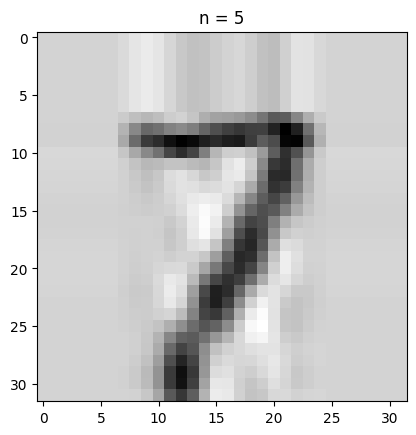

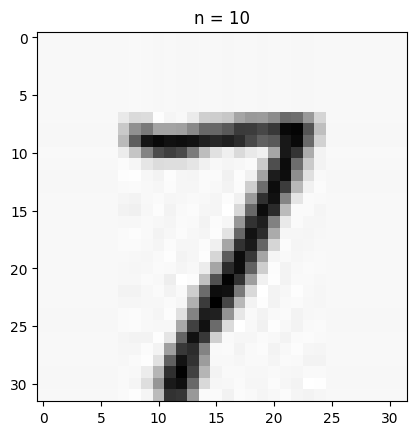

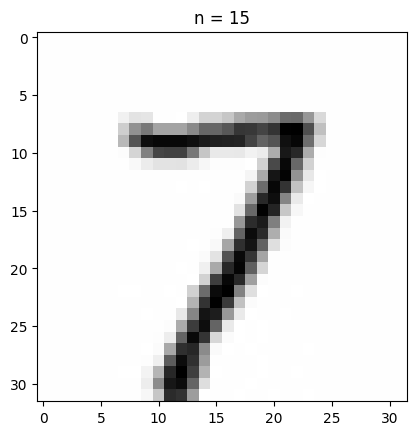

In [24]:
# Then we look at the effect of the classic singular value decomposition
U, sigma, V = np.linalg.svd(imgmat)

for i in range(5, 16, 5):
    reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = f"n = {i}"
    plt.title(title)
    plt.show()

In [27]:
# Set circuit parameters
cir_depth = 40      # depth of circuit
num_qubits = 5      # Number of qubits

# Hyper-parameters
RANK = 4           # Set the number of rank you want to learn
ITR = 100           # Number of iterations
LR = 0.05           # Learning rate
SEED = 14           # Random number seed

# Set the learning weight
weight = np.arange(2 * RANK, 0, -2).astype('complex128')

# Convert the image into numpy array
def Mat_generator():
    imgmat = np.array(list(img.getdata(band=0)), float)
    imgmat.shape = (img.size[1], img.size[0])
    lenna = np.matrix(imgmat)
    return lenna.astype('complex128')

M_err = Mat_generator()
U, D, V_dagger = np.linalg.svd(Mat_generator(), full_matrices=True)

In [ ]:
# Record the optimization process
loss_list, singular_value_list = [], []
U_learned, V_dagger_learned = [], []
    
# Construct the VQSVD network and train
net = VQSVD(matrix=Mat_generator(), weights=weight, num_qubits=num_qubits, depth=cir_depth, rank=RANK, lr=LR, itr=ITR, seed=SEED)
loss_list, singular_value_list = net.train()

# Record the last two unitary matrices learned
U_learned = net.get_matrix_U().numpy()
V_dagger_learned = net.get_matrix_V().numpy().conj().T

singular_value_pnp = pnp.array(singular_value_list[-1]) # This is still a pnp.ndarray
singular_value = singular_value_pnp.numpy()
mat = np.matrix(U_learned.real[:, :RANK]) * np.diag(singular_value[:RANK])* np.matrix(V_dagger_learned.real[:RANK, :])

reconstimg = mat
plt.imshow(reconstimg, cmap='gray')